In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
from shapely.geometry import Polygon
import time

from sklearn.linear_model import LinearRegression, LogisticRegression
import pysal as ps
import spacv
from spacv.grid_builder import *
from scipy.spatial.distance import pdist, squareform
from spacv.utils import *
import spreg
from shapely.geometry import Point
from matplotlib.patches import RegularPolygon
from matplotlib.collections import PolyCollection
import math

np.set_printoptions(precision=7)
np.set_printoptions(formatter={'float': '{: 0.3f}'.format})
np.printoptions(suppress=True)

/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:88: UserWarning: The Shapely GEOS version (3.7.2dev-CAPI-1.11.2 0) is incompatible with the GEOS version PyGEOS was compiled with (3.8.1-CAPI-1.13.3). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


# Sklearn integration

In [3]:
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.svm import SVC

df = gpd.read_file('/opt/conda/lib/python3.7/site-packages/libpysal/examples/baltim/baltim.shp')

XYs = df['geometry']
X = df[['NROOM', 'DWELL', 'NBATH', 'PRICE', 'LOTSZ', 'SQFT']]
y = df['PATIO']

In [24]:
skcv = spacv.SKCV(buffer_radius=5).split(XYs)

svc = SVC()

In [25]:
cross_val_score(svc, 
                X, 
                y, 
                cv = skcv)

array([ 0.833,  0.857,  0.789,  1.000,  0.913,  0.773,  0.545,  0.957,
        0.850,  1.000])

In [91]:
parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}

In [92]:
clf = GridSearchCV(estimator=svc, 
                   param_grid=parameters, 
                   cv = skcv # An iterable yielding (train, test) splits as arrays of indices
                  )

clf.fit(X, y)

In [94]:
clf.best_params_

{'C': 10, 'kernel': 'rbf'}

# Speed

In [2]:
n = 1000000

x = np.random.randint(0, 3000, n)
y = np.random.randint(0, 3000, n)

gdf = gpd.GeoDataFrame({'geometry': gpd.points_from_xy(x,y)})
data = np.random.random((n,5))

y, gdf['V2'], gdf['V3'], gdf['V4'], gdf['V5'] = data[:,0], data[:,1], data[:,2], data[:,3], data[:,4]
X = gdf[['V2', 'V3', 'V4', 'V5']].values

XYs = gdf['geometry']

### H-blocking

In [31]:
cv = spacv.HBLOCK(10,5, method='unique', buffer_radius=500)

In [32]:
%%timeit
for tr,te in cv.split(XYs):
    pass

31.6 s ± 1.1 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Spatial K-fold

In [64]:
cv = spacv.SKCV(folds=10)

In [65]:
%%timeit
for tr,te in cv.split(XYs):
    pass

1min 53s ± 3.06 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [66]:
cv = spacv.SKCV(folds=10, buffer_radius=500)

In [67]:
%%timeit
for tr,te in cv.split(XYs):
    pass

1min 56s ± 3.54 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Repeat Spatial K-fold

In [68]:
cv = spacv.RepeatSKCV(folds=10, n_repeats=2)

In [69]:
%%timeit
for tr,te in cv.split(XYs):
    pass

3min 40s ± 1.79 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [70]:
cv = spacv.RepeatSKCV(folds=10, n_repeats=2, buffer_radius=500)

In [71]:
%%timeit
for tr,te in cv.split(XYs):
    pass

3min 45s ± 3.98 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


### SLOO

In [9]:
sample_XYs = XYs.sample(100000)

In [10]:
cv = spacv.SKCV(folds= len(sample_XYs))

In [12]:
%%timeit -r 1 -n 1
for tr,te in cv.split(sample_XYs):
    pass

8min 6s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


# Ad-hoc grid/fold construction

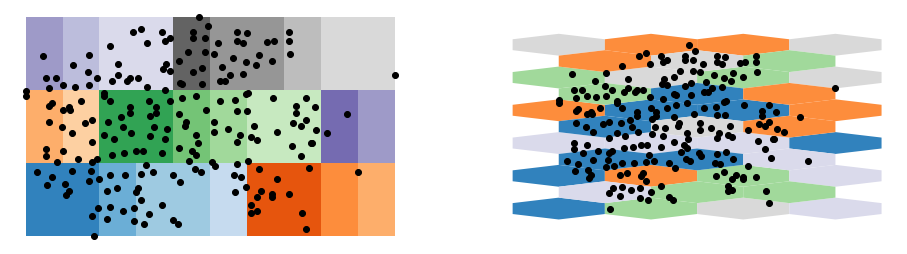

In [3]:
f, ax = plt.subplots(1,2, figsize=(16,16))
construct_blocks(XYs, tiles_x=10, tiles_y=3, method='unique').plot(column='grid_id', cmap='tab20c',ax=ax[0])

hexgrid = construct_blocks(XYs, tiles_x=3, tiles_y=5, 
                 method='optimized_random', n_sims=10, data=X,
                 n_groups=5, shape='hex')
hexgrid.plot(column='grid_id', cmap='tab20c',ax=ax[1])
XYs.plot(ax=ax[0], color='black'),XYs.plot(ax=ax[1], color='black')
ax[0].axis('off'), ax[1].axis('off')
plt.show()

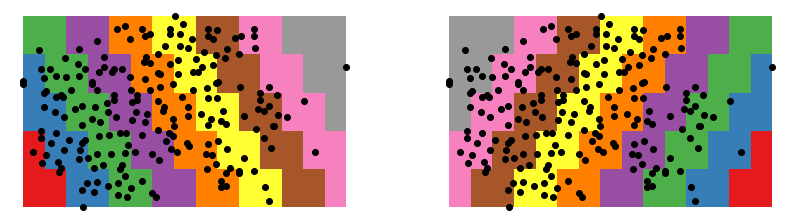

In [4]:
f, ax = plt.subplots(1,2, figsize=(14,12))

construct_blocks(XYs, method='systematic', tiles_x=15, tiles_y=5, direction='anti').plot(column='grid_id', cmap='Set1', ax=ax[0])
construct_blocks(XYs, method='systematic', tiles_x=15, tiles_y=5, direction='diagonal').plot(column='grid_id', cmap='Set1', ax=ax[1])

XYs.plot(ax=ax[0], color='black')
XYs.plot(ax=ax[1], color='black')
ax[0].axis('off'), ax[1].axis('off');

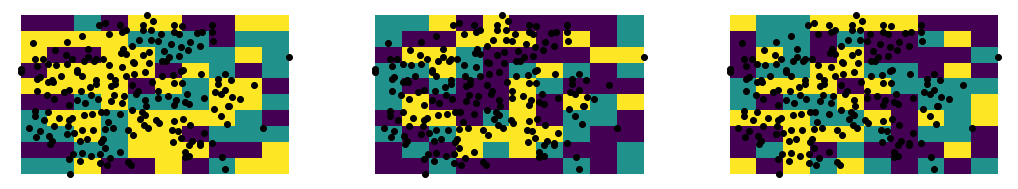

In [9]:
f, ax = plt.subplots(1,3, figsize=(18,20))
construct_blocks(df, method='random', tiles_x=10, tiles_y=10, n_groups=3).plot(column='grid_id', ax=ax[0])
construct_blocks(df, method='random', tiles_x=10, tiles_y=10, n_groups=3).plot(column='grid_id', ax=ax[1])
construct_blocks(df, method='random', tiles_x=10, tiles_y=10, n_groups=3).plot(column='grid_id', ax=ax[2])
XYs.plot(ax=ax[0], color='black')
XYs.plot(ax=ax[1], color='black')
XYs.plot(ax=ax[2], color='black')
ax[0].axis('off'), ax[1].axis('off'), ax[2].axis('off');

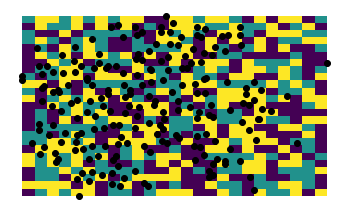

In [6]:
f, ax = plt.subplots(1)
construct_blocks(df, method='optimized_random', data=X, tiles_x=25, tiles_y=25, 
                 n_groups=3, n_sims=10, distance_metric='euclidean').plot(column='grid_id', ax=ax)
df.plot(ax=ax, color='black')
ax.axis('off');

# Visualisaton

In [4]:
from spacv.visualisation import *

In [5]:
lags = np.arange(0, 130, 20)
bw = 10

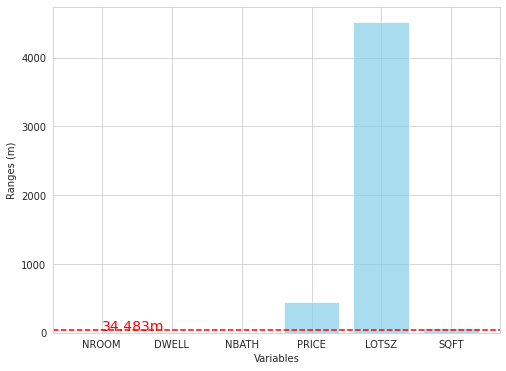

In [7]:
f, ax = plot_autocorrelation_ranges(XYs, X, lags, bw)

In [10]:
new_data = df.loc[0:25]
training_data = df.loc[25:]

In [17]:
cols = X.columns

In [19]:
plot_aoa(new_data, training_data, columns=cols, figsize= (8,8), fold_indices=None)

NameError: name 'fold_indices' is not defined

# Future

* Spatially-explicit GCV
* Bootstrap samples from within folds testing